In [106]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa import tsatools
from statsmodels.tsa.stattools import adfuller
from dmba import regressionSummary
from matplotlib.patches import Ellipse
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import date2num
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# import pytabular as pytab
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import shapiro,kstest, norm
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
daily_peak_df=pd.read_excel('Data/niti/Daily_Peak_Demand7.xlsx',skipfooter=4)

daily_peak_df['Date']=pd.to_datetime(daily_peak_df['Date'],format='%d-%m-%Y')
daily_peak_ts=pd.Series(daily_peak_df['Peak Demand Met'].values,index=daily_peak_df['Date'],name='Daily_Peak')
daily_peak_ts.index=pd.DatetimeIndex(daily_peak_ts.index,freq='d')
daily_peak_df.dropna(inplace=True)
daily_peak_ts.dropna(inplace=True)

In [192]:
daily_peak_df=pd.DataFrame(daily_peak_ts)
monthly_data = daily_peak_df.resample('M').mean()

nValid=24
nTrain=len(monthly_data)-nValid
train_df=monthly_data[:nTrain]
test_df=monthly_data[nTrain:]

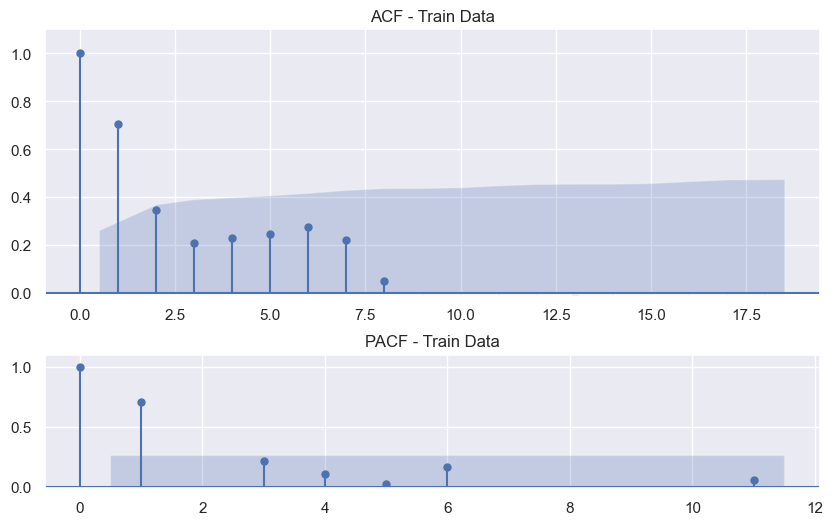

In [59]:
#check for stationarity

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10/1.68),gridspec_kw={'height_ratios': [2, 1]})

fig=tsaplots.plot_acf(train_df['Daily_Peak'],ax=axes[0])
axes[0].set_title ('ACF - Train Data')
axes[0].set_ylim(-0.01,1.1)
fig=tsaplots.plot_pacf(train_df['Daily_Peak'],ax=axes[1],lags=11)
axes[1].set_title ('PACF - Train Data')
axes[1].set_ylim(-0.01,1.1)
plt.subplots_adjust(hspace=0.3)
fig.savefig('Data/images/Pacf_.png',dpi=400)

In [39]:
adfuller(test_df)[1]

0.10727524496686852

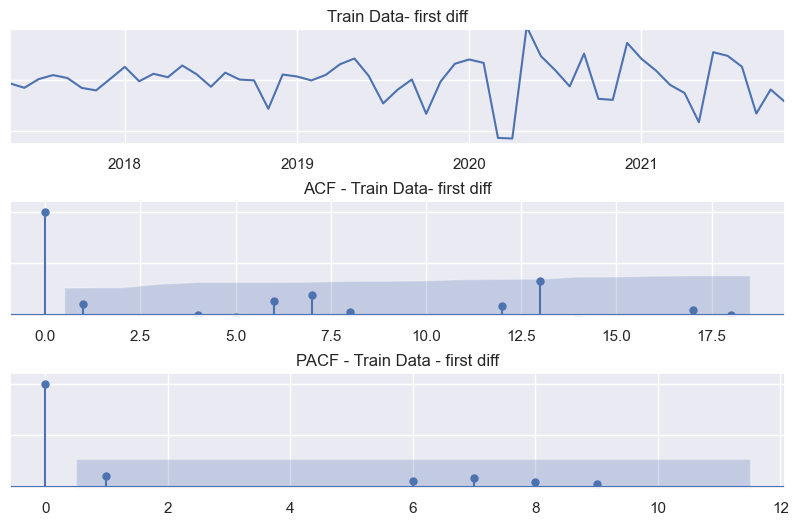

In [60]:
#differencing and ACF PACF
sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10/1.68))
fig=train_df_diff.plot(ax=axes[0])
axes[0].set_title ('Train Data- first diff')
axes[0].set_ylim(-25000,20000)
axes[0].set_xlabel('')
axes[0].legend().set_visible(False)

fig=tsaplots.plot_acf(train_df_diff['Daily_Peak'],ax=axes[1])
axes[1].set_title ('ACF - Train Data- first diff')
axes[1].set_ylim(-0.01,1.1)
fig=tsaplots.plot_pacf(train_df_diff['Daily_Peak'],ax=axes[2],lags=11)
axes[2].set_title ('PACF - Train Data - first diff')
axes[2].set_ylim(-0.01,1.1)
plt.subplots_adjust(hspace=0.5)
for ax in axes:
    ax.set_yticklabels([])

fig.savefig('Data/images/Pacf_diff.png',dpi=400)

In [61]:
adfuller(train_df_diff)[1]

7.23026007391411e-06

In [65]:
ar_model=ARIMA(train_df,order=(0,1,0))
model_fit=ar_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Daily_Peak   No. Observations:                   56
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -573.861
Date:                Fri, 24 Nov 2023   AIC                           1149.722
Time:                        14:09:21   BIC                           1151.729
Sample:                    04-30-2017   HQIC                          1150.498
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.643e+07   1.01e+07      6.561      0.000    4.66e+07    8.63e+07
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                 5.40
Prob(Q):                              0.43   Pr

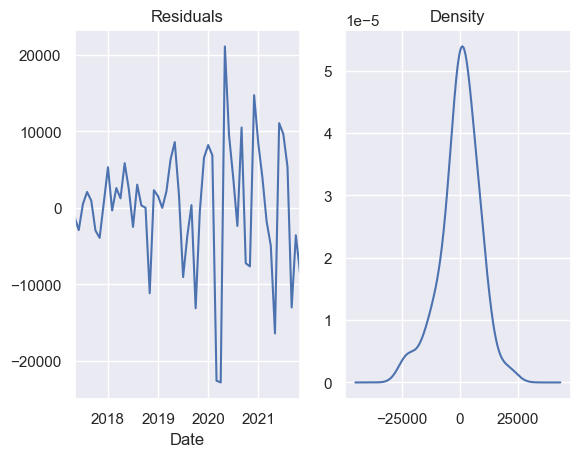

In [77]:
residuals=model_fit.resid[1:]
fig,ax=plt.subplots(1,2)
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
ax[1].set_ylabel('')
fig.savefig('Data/images/Arima_Resid.png',dpi=400)

In [82]:
#Normality Shapiro test

stat, p_value = shapiro(residuals)
print(p_value)

0.0701969787478447


<Axes: xlabel='Date'>

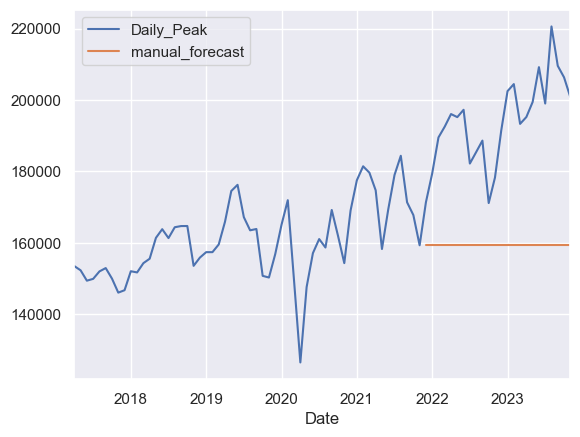

In [87]:
forecast_value=model_fit.forecast(len(test_df))
monthly_data['manual_forecast']=[None]*len(train_df)+list(forecast_value)
monthly_data.plot()

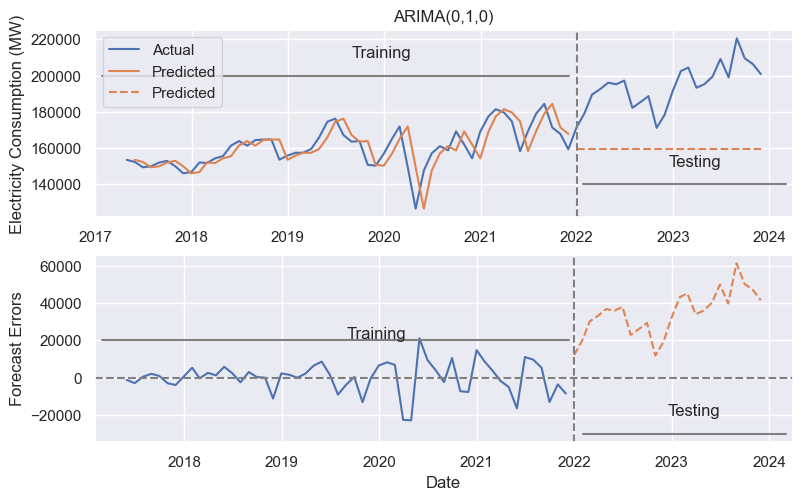

In [109]:
ar_model=ARIMA(train_df,order=(0,1,0))
model_fit=ar_model.fit()
ar_fitted=model_fit.fittedvalues
ar_fitted[0]=np.nan
col_remove=['Month','Daily_Peak']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9/1.68))

sns.lineplot(x=monthly_data.index, y=monthly_data['Daily_Peak'],
             ax=axes[0],label='Actual')
sns.lineplot(x=monthly_data.index[:nTrain],y=ar_fitted,
            ax=axes[0],label='Predicted')
sns.lineplot(x=monthly_data.index[nTrain:], y=model_fit.forecast(len(test_df)),
             ax=axes[0],color='C1', linestyle='dashed',label='Predicted')

# sns.lineplot(x=monthly_data.index[:nTrain], y=expSmoothFit.predict(train_df.drop(columns=col_remove)),
#              ax=axes[0],label='Predicted')
# sns.lineplot(x=monthly_data.index[nTrain:], y=monthly_lm_sea.predict(test_df.drop(columns=col_remove)),
#              ax=axes[0],color='C1', linestyle='dashed',label='Predicted')
axes[0].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[0].axhline(y=200000, color='grey', linestyle='-',xmax=.68,xmin=.01)
axes[0].text(18139.0, 210000, 'Training')

axes[0].axhline(140000, color='grey', linestyle='-', xmax=.99,xmin=.70)
axes[0].text(19341.5, 150000, 'Testing')
axes[0].set_ylabel('Electricity Consumption (MW)')
axes[0].set_xlabel('')
axes[0].set_title('ARIMA(0,1,0)')
axes[0].legend()


residual = train_df['Daily_Peak'] - model_fit.fittedvalues


sns.lineplot(x=monthly_data.index[:nTrain], y=residual,
             ax=axes[1])

residual = test_df['Daily_Peak'] - model_fit.forecast(len(test_df))
sns.lineplot(x=monthly_data.index[nTrain:], y=residual,
             ax=axes[1],color='C1', linestyle='dashed')
axes[1].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[1].axhline(y=20000, color='grey', linestyle='-', 
                xmax=.68,xmin=.01)
axes[1].text(18139.0, 21000, 'Training')

axes[1].axhline(-30000, color='grey', linestyle='-',
                xmax=.99,xmin=.70)
axes[1].text(19341.5, -20000, 'Testing')


axes[1].set_ylabel('Forecast Errors')

axes[1].axhline(0.0, color='grey', linestyle='--')

plt.savefig('Data/images/ARIMA.png',dpi=400)
plt.show()

In [99]:
ar_fitted.tail()

Date
2021-07-31    169384.000000
2021-08-31    179028.451613
2021-09-30    184398.161290
2021-10-31    171379.866667
2021-11-30    167800.516129
Freq: M, dtype: float64

In [100]:
predictions_train=ar_fitted
y_train=train_df['Daily_Peak']

mae_train = round(mean_absolute_error(y_train[1:], predictions_train[1:]),2)
mape_train = round(mean_absolute_percentage_error(y_train[1:], predictions_train[1:]),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train[1:], predictions_train[1:])),2)

#test

predictions_test=model_fit.forecast(len(test_df))
y_test=test_df['Daily_Peak']

mae_test = round(mean_absolute_error(y_test, predictions_test),2)
mape_test = round(mean_absolute_percentage_error(y_test, predictions_test),2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, predictions_test)),2)

# make latex table

data = {
    ('', 'Measure'): ['MAE', 'MAPE', 'RMSE'],
    ('OLS', 'Test'): [mae_train, mape_train, rmse_train],
    ('OLS', 'Train'): [mae_test, mape_test, rmse_test]
}
df = pd.DataFrame(data)
latex_table=df.to_latex(index=False, multirow=True, multicolumn=True)

print(latex_table)

\begin{tabular}{lrr}
\toprule
 & \multicolumn{2}{r}{OLS} \\
Measure & Test & Train \\
\midrule
MAE & 6000.610000 & 34800.020000 \\
MAPE & 0.040000 & 0.180000 \\
RMSE & 8224.000000 & 36776.430000 \\
\bottomrule
\end{tabular}



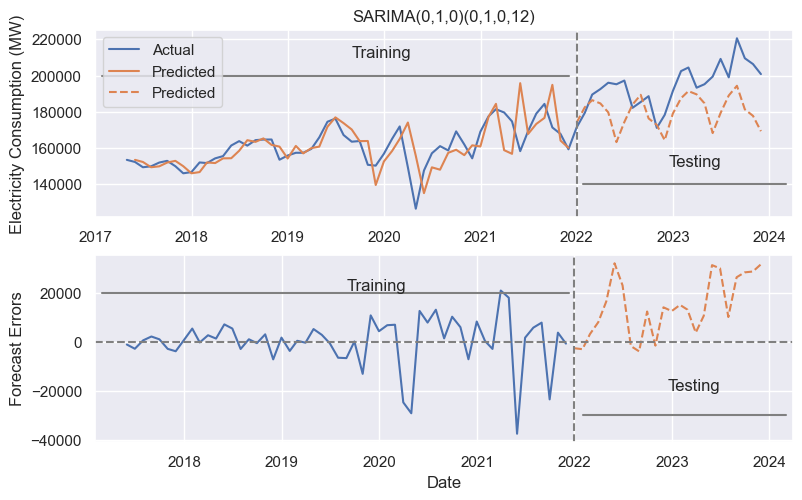

In [193]:
sar_model=SARIMAX(train_df,order=(0,1,0),seasonal_order=(0,1,0,12))
model_fit=sar_model.fit()
ar_fitted=model_fit.fittedvalues
ar_fitted[0]=np.nan
ar_fitted[12]=train_df[11:12]['Daily_Peak']
col_remove=['Month','Daily_Peak']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9/1.68))

sns.lineplot(x=monthly_data.index, y=monthly_data['Daily_Peak'],
             ax=axes[0],label='Actual')
sns.lineplot(x=monthly_data.index[:nTrain],y=ar_fitted,
            ax=axes[0],label='Predicted')
sns.lineplot(x=monthly_data.index[nTrain:], y=model_fit.forecast(len(test_df)),
             ax=axes[0],color='C1', linestyle='dashed',label='Predicted')

# sns.lineplot(x=monthly_data.index[:nTrain], y=expSmoothFit.predict(train_df.drop(columns=col_remove)),
#              ax=axes[0],label='Predicted')
# sns.lineplot(x=monthly_data.index[nTrain:], y=monthly_lm_sea.predict(test_df.drop(columns=col_remove)),
#              ax=axes[0],color='C1', linestyle='dashed',label='Predicted')
axes[0].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[0].axhline(y=200000, color='grey', linestyle='-',xmax=.68,xmin=.01)
axes[0].text(18139.0, 210000, 'Training')

axes[0].axhline(140000, color='grey', linestyle='-', xmax=.99,xmin=.70)
axes[0].text(19341.5, 150000, 'Testing')
axes[0].set_ylabel('Electricity Consumption (MW)')
axes[0].set_xlabel('')
axes[0].set_title('SARIMA(0,1,0)(0,1,0,12)')
axes[0].legend()


residual = train_df['Daily_Peak'] - model_fit.fittedvalues


sns.lineplot(x=monthly_data.index[:nTrain], y=residual,
             ax=axes[1])

residual = test_df['Daily_Peak'] - model_fit.forecast(len(test_df))
sns.lineplot(x=monthly_data.index[nTrain:], y=residual,
             ax=axes[1],color='C1', linestyle='dashed')
axes[1].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[1].axhline(y=20000, color='grey', linestyle='-', 
                xmax=.68,xmin=.01)
axes[1].text(18139.0, 21000, 'Training')

axes[1].axhline(-30000, color='grey', linestyle='-',
                xmax=.99,xmin=.70)
axes[1].text(19341.5, -20000, 'Testing')


axes[1].set_ylabel('Forecast Errors')

axes[1].axhline(0.0, color='grey', linestyle='--')

plt.savefig('Data/images/SARIMAX.png',dpi=400)
plt.show()

In [133]:
train_df[11:12]['Daily_Peak']

Date
2018-03-31    154340.387097
Freq: M, Name: Daily_Peak, dtype: float64

In [138]:
predictions_train=ar_fitted
y_train=train_df['Daily_Peak']

mae_train = round(mean_absolute_error(y_train[1:], predictions_train[1:]),2)
mape_train = round(mean_absolute_percentage_error(y_train[1:], predictions_train[1:]),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train[1:], predictions_train[1:])),2)

#test

predictions_test=model_fit.forecast(len(test_df))
y_test=test_df['Daily_Peak']

mae_test = round(mean_absolute_error(y_test, predictions_test),2)
mape_test = round(mean_absolute_percentage_error(y_test, predictions_test),2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, predictions_test)),2)

# make latex table

data = {
    ('', 'Measure'): ['MAE', 'MAPE', 'RMSE'],
    ('OLS', 'Test'): [mae_train, mape_train, rmse_train],
    ('OLS', 'Train'): [mae_test, mape_test, rmse_test]
}
df = pd.DataFrame(data)
latex_table=df.to_latex(index=False, multirow=True, multicolumn=True)

print(latex_table)

\begin{tabular}{lrr}
\toprule
 & \multicolumn{2}{r}{OLS} \\
Measure & Test & Train \\
\midrule
MAE & 6614.640000 & 15070.260000 \\
MAPE & 0.040000 & 0.080000 \\
RMSE & 10180.370000 & 18473.810000 \\
\bottomrule
\end{tabular}



In [176]:
mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [170]:
monthly_data['covid']=1
start_date=pd.Timestamp('2020-03-01')
end_date=pd.Timestamp('2020-05-31')
mask = (monthly_data.index >= start_date) & (monthly_data.index <= end_date)
monthly_data.loc[mask,'covid']=0

<Axes: xlabel='Date'>

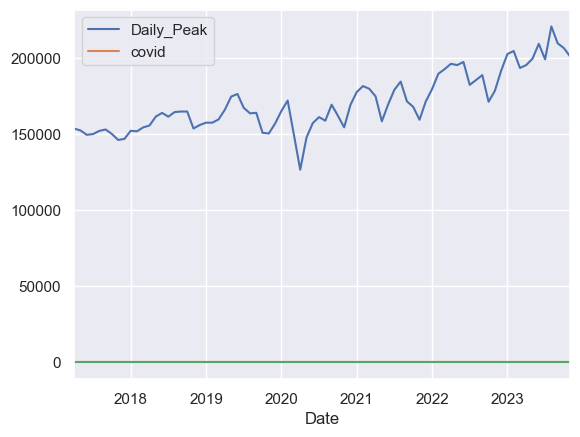

In [194]:
# 1Mar -31 May 20

daily_peak_df=pd.DataFrame(daily_peak_ts)
monthly_data = daily_peak_df.resample('M').mean()
monthly_data['covid']=0
start_date=pd.Timestamp('2020-03-01')
end_date=pd.Timestamp('2020-05-31')
mask = (monthly_data.index >= start_date) & (monthly_data.index <= end_date)
monthly_data.loc[mask,'covid']=0
nValid=24
nTrain=len(monthly_data)-nValid
train_df=monthly_data[:nTrain]
test_df=monthly_data[nTrain:]
monthly_data.plot()
monthly_data['covid'].plot()
# monthly_data.diff(1).plot()
# monthly_data.diff(12).plot()

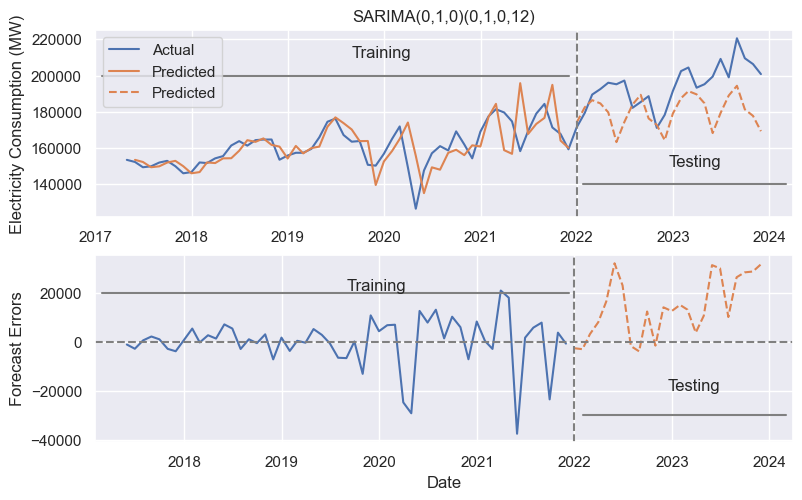

In [195]:
sar_model=SARIMAX(train_df['Daily_Peak'],order=(0,1,0),seasonal_order=(0,1,0,12),exog=train_df['covid'])
model_fit=sar_model.fit()
ar_fitted=model_fit.fittedvalues
ar_fitted[0]=np.nan
ar_fitted[12]=train_df[11:12]['Daily_Peak']
col_remove=['Month','Daily_Peak']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 9/1.68))

sns.lineplot(x=monthly_data.index, y=monthly_data['Daily_Peak'],
             ax=axes[0],label='Actual')
sns.lineplot(x=monthly_data.index[:nTrain],y=ar_fitted,
            ax=axes[0],label='Predicted')
sns.lineplot(x=monthly_data.index[nTrain:], y=model_fit.forecast(len(test_df),exog=test_df['covid']),
             ax=axes[0],color='C1', linestyle='dashed',label='Predicted')

# sns.lineplot(x=monthly_data.index[:nTrain], y=expSmoothFit.predict(train_df.drop(columns=col_remove)),
#              ax=axes[0],label='Predicted')
# sns.lineplot(x=monthly_data.index[nTrain:], y=monthly_lm_sea.predict(test_df.drop(columns=col_remove)),
#              ax=axes[0],color='C1', linestyle='dashed',label='Predicted')
axes[0].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[0].axhline(y=200000, color='grey', linestyle='-',xmax=.68,xmin=.01)
axes[0].text(18139.0, 210000, 'Training')

axes[0].axhline(140000, color='grey', linestyle='-', xmax=.99,xmin=.70)
axes[0].text(19341.5, 150000, 'Testing')
axes[0].set_ylabel('Electricity Consumption (MW)')
axes[0].set_xlabel('')
axes[0].set_title('SARIMA(0,1,0)(0,1,0,12)')
axes[0].legend()


residual = train_df['Daily_Peak'] - model_fit.fittedvalues


sns.lineplot(x=monthly_data.index[:nTrain], y=residual,
             ax=axes[1])

residual = test_df['Daily_Peak'] - model_fit.forecast(len(test_df),exog=test_df['covid'])
sns.lineplot(x=monthly_data.index[nTrain:], y=residual,
             ax=axes[1],color='C1', linestyle='dashed')
axes[1].axvline(x=monthly_data.index[nTrain], color='grey', linestyle='--')
xmax=date2num(monthly_data.index[nTrain])/date2num(monthly_data.index[-1])
axes[1].axhline(y=20000, color='grey', linestyle='-', 
                xmax=.68,xmin=.01)
axes[1].text(18139.0, 21000, 'Training')

axes[1].axhline(-30000, color='grey', linestyle='-',
                xmax=.99,xmin=.70)
axes[1].text(19341.5, -20000, 'Testing')


axes[1].set_ylabel('Forecast Errors')

axes[1].axhline(0.0, color='grey', linestyle='--')

plt.savefig('Data/images/SARIMAX_EXOG.png',dpi=400)
plt.show()

In [199]:
predictions_train=ar_fitted
y_train=train_df['Daily_Peak']

mae_train = round(mean_absolute_error(y_train[1:], predictions_train[1:]),2)
mape_train = round(mean_absolute_percentage_error(y_train[1:], predictions_train[1:]),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train[1:], predictions_train[1:])),2)

#test

predictions_test=model_fit.forecast(len(test_df),exog=test_df['covid'])
y_test=test_df['Daily_Peak']

mae_test = round(mean_absolute_error(y_test, predictions_test),2)
mape_test = round(mean_absolute_percentage_error(y_test, predictions_test),2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, predictions_test)),2)

# make latex table

data = {
    ('', 'Measure'): ['MAE', 'MAPE', 'RMSE'],
    ('OLS', 'Test'): [mae_train, mape_train, rmse_train],
    ('OLS', 'Train'): [mae_test, mape_test, rmse_test]
}
df = pd.DataFrame(data)
latex_table=df.to_latex(index=False, multirow=True, multicolumn=True)

print(latex_table)

\begin{tabular}{lrr}
\toprule
 & \multicolumn{2}{r}{OLS} \\
Measure & Test & Train \\
\midrule
MAE & 6614.640000 & 15070.260000 \\
MAPE & 0.040000 & 0.080000 \\
RMSE & 10180.370000 & 18473.810000 \\
\bottomrule
\end{tabular}



In [198]:
predictions_train=ar_fitted
y_train=train_df['Daily_Peak']

mae_train = round(mean_absolute_error(y_train[1:], predictions_train[1:]),2)
mape_train = round(mean_absolute_percentage_error(y_train[1:], predictions_train[1:]),2)
rmse_train = round(np.sqrt(mean_squared_error(y_train[1:], predictions_train[1:])),2)

#test

predictions_test=model_fit.forecast(len(test_df))
y_test=test_df['Daily_Peak']

mae_test = round(mean_absolute_error(y_test, predictions_test),2)
mape_test = round(mean_absolute_percentage_error(y_test, predictions_test),2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, predictions_test)),2)

# make latex table

data = {
    ('', 'Measure'): ['MAE', 'MAPE', 'RMSE'],
    ('OLS', 'Test'): [mae_train, mape_train, rmse_train],
    ('OLS', 'Train'): [mae_test, mape_test, rmse_test]
}
df = pd.DataFrame(data)
latex_table=df.to_latex(index=False, multirow=True, multicolumn=True)

print(latex_table)

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [117]:
sar_model.summary()

AttributeError: 'ARIMA' object has no attribute 'summary'